US Precipitation and Temperature Analysis
====

Example of an analysis of gridded ensemble precipitation and temperature estimates over the contiguous United States

by [Joe Hamman](https://github.com/jhamman/) and [Matthew Rocklin](https://github.com/mrocklin/)


For this example, we'll open a 100 member ensemble of precipitation and temperature data. Each ensemble member is stored in a seperate netCDF file and are otherwise formatted identically. The analysis we do below is quite simple but the problem is a good illustration of an IO bound task. 

Link to dataset: https://www.earthsystemgrid.org/dataset/gridded_precip_and_temp.html

In [1]:
%matplotlib inline

import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

### Connect to Dask Distributed Cluster

In [2]:
from dask.distributed import Client
client = Client(scheduler_file='/glade/scratch/jhamman/scheduler.json')
client

Client Scheduler: tcp://10.148.5.204:8786 Dashboard: http://10.148.5.204:8787,Cluster Workers: 65 Cores: 390 Memory: 1430.00 GB


### Open the dataset using Xarray

Here we open the 100 member ensemble. Each ensemble member is stored as a single file and we use `xarray.open_mfdataset` to concatenate them along a new `ensemble` dimension. In addition to chunking along the `ensemble` dimension (defaults to 1 chunk per file), we'll also chunk along the `time` dimension. 

In [3]:
ds = xr.open_mfdataset('/glade/u/home/jhamman/workdir/GARD_inputs/newman_ensemble/conus_ens_[01]*',
                       engine='netcdf4', concat_dim='ensemble', chunks={'time': 366})

In [4]:
# These clean up tasks can be removed after xarray 0.10 is release
ds['elevation'] = ds['elevation'].isel(ensemble=0, drop=True)
ds['mask'] = ds['mask'].isel(ensemble=0, drop=True).astype(np.int)
ds['mask'] = ds['mask'].where(ds['mask'] > 0)

#### Metadata
Let's start by printing some metadata before we get started with the fun


In [5]:
print('ds size in GB {:0.2f}\n'.format(ds.nbytes / 1e9))

ds.info()

ds size in GB 5011.38

xarray.Dataset {
dimensions:
	ensemble = 100 ;
	lat = 224 ;
	lon = 464 ;
	time = 12054 ;

variables:
	datetime64[ns] time(time) ;
		time:standard_name = time ;
	float64 lon(lon) ;
		lon:long_name = longitude ;
		lon:units = degrees_east ;
		lon:standard_name = latitude ;
	float64 lat(lat) ;
		lat:long_name = latitude ;
		lat:units = degrees_north ;
		lat:standard_name = latitude ;
	float64 elevation(lat, lon) ;
		elevation:units = meters ;
		elevation:long_name = Terrain Elevation ;
		elevation:standard_name = elevation ;
	float64 pcp(ensemble, time, lat, lon) ;
		pcp:long_name = Daily estimated precipitation accumulation ;
		pcp:units = kg m-2 ;
		pcp:standard_name = precipitation ;
	float64 t_mean(ensemble, time, lat, lon) ;
		t_mean:long_name = Daily estimated mean temperature ;
		t_mean:units = degC ;
	float64 t_range(ensemble, time, lat, lon) ;
		t_range:long_name = Daily estimated diurnal temperature range ;
		t_range:units = degC ;
	float64 mask(lat, lon) 

### Figure: Domain mask
A quick plot of the mask to give us an idea of the spatial domain we're working with


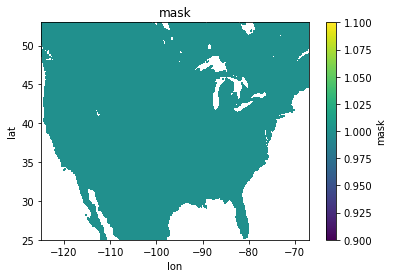

In [6]:
ds['mask'].plot()
plt.title('mask')

### Look! All these arrays are dask arrays under the hood. Note the chunk sizes


In [7]:
for name, da in ds.data_vars.items():
    print(name, da.data)

elevation dask.array<getitem, shape=(224, 464), dtype=float64, chunksize=(224, 464)>
pcp dask.array<concatenate, shape=(100, 12054, 224, 464), dtype=float64, chunksize=(1, 366, 224, 464)>
t_mean dask.array<concatenate, shape=(100, 12054, 224, 464), dtype=float64, chunksize=(1, 366, 224, 464)>
t_range dask.array<concatenate, shape=(100, 12054, 224, 464), dtype=float64, chunksize=(1, 366, 224, 464)>
mask dask.array<where, shape=(224, 464), dtype=float64, chunksize=(224, 464)>
t_max dask.array<concatenate, shape=(100, 12054, 224, 464), dtype=float64, chunksize=(1, 366, 224, 464)>
t_min dask.array<concatenate, shape=(100, 12054, 224, 464), dtype=float64, chunksize=(1, 366, 224, 464)>


### Intra-ensemble range
We can start by calculating the intra-ensemble range for all the mean daily temperature in this dataset.


In [8]:
# calculates the long term mean along the time dimension
da_mean = ds['t_mean'].mean(dim='time')
# calculate the intra-ensemble range of long term means
da_spread = da_mean.max(dim='ensemble') - da_mean.min(dim='ensemble')
da_spread

<xarray.DataArray 't_mean' (lat: 224, lon: 464)>
dask.array<sub, shape=(224, 464), dtype=float64, chunksize=(224, 464)>
Coordinates:
  * lon      (lon) float64 -124.9 -124.8 -124.7 -124.6 -124.4 -124.3 -124.2 ...
  * lat      (lat) float64 25.06 25.19 25.31 25.44 25.56 25.69 25.81 25.94 ...

### Calling compute
The expressions above didn't actually compute anything. They just build the dask task graph. To do the computations, we call the `compute` method:

In [9]:
%time da_spread = da_spread.compute()

CPU times: user 1.77 s, sys: 40 ms, total: 1.81 s
Wall time: 4min 19s


#### Figure: Intra-ensemble range


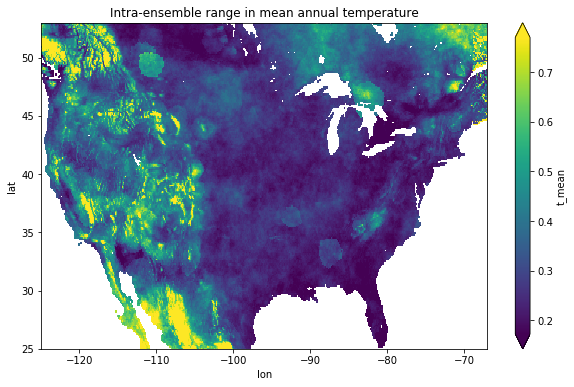

In [10]:
da_spread.plot(robust=True, figsize=(10, 6))
plt.title('Intra-ensemble range in mean annual temperature')

### Persisting data on the cluster

(Make sure you have well over 300GB of RAM on your cluster, you can change the `ensemble=slice(0, 25)` section below to use more/less ensemble members.

Most of the time spent in the last calculation was loading data from disk.  After we were done with this data, Dask threw it away to free up memory.  If we plan to reuse the same dataset many times then we may want to `persist` it in memory.

In [11]:
t_mean = ds['t_mean'].isel(ensemble=slice(0, 25))
t_mean = t_mean.persist()
t_mean

<xarray.DataArray 't_mean' (ensemble: 25, time: 12054, lat: 224, lon: 464)>
dask.array<getitem, shape=(25, 12054, 224, 464), dtype=float64, chunksize=(1, 366, 224, 464)>
Coordinates:
  * time     (time) datetime64[ns] 1980-01-01 1980-01-02 1980-01-03 ...
  * lon      (lon) float64 -124.9 -124.8 -124.7 -124.6 -124.4 -124.3 -124.2 ...
  * lat      (lat) float64 25.06 25.19 25.31 25.44 25.56 25.69 25.81 25.94 ...
Dimensions without coordinates: ensemble
Attributes:
    long_name:  Daily estimated mean temperature
    units:      degC

Now the t_mean DataArray is resident in memory on our workers.  We can repeat our computation from last time much more quickly.

In [12]:
%%time
temp_mean = t_mean.mean(dim='time')
spread = temp_mean.max(dim='ensemble') - temp_mean.min(dim='ensemble')  # calculates the intra-ensemble range of long term means
mean = spread.compute()

CPU times: user 588 ms, sys: 32 ms, total: 620 ms
Wall time: 1min 17s


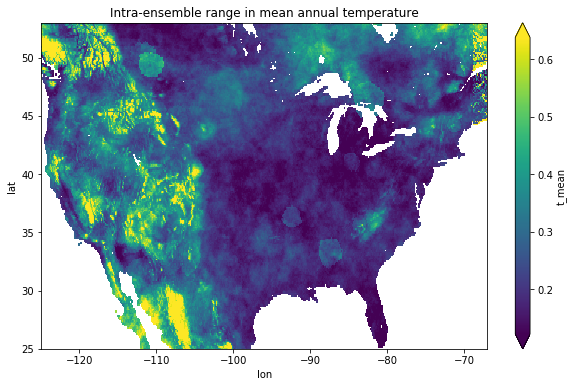

In [13]:
mean.plot(robust=True, figsize=(10, 6))
plt.title('Intra-ensemble range in mean annual temperature')

And we can also modify the computation and try something new.  Keeping data in memory allows to *iterate quickly*, which is the whole point of this exercise.

In [14]:
%%time
temp_mean = t_mean.std(dim='time')
spread = temp_mean.max(dim='ensemble') - temp_mean.min(dim='ensemble')  # calculates the intra-ensemble range of long term means
std = spread.compute()

CPU times: user 428 ms, sys: 8 ms, total: 436 ms
Wall time: 9 s


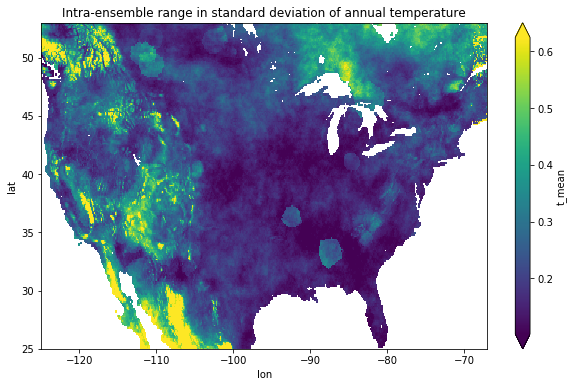

In [15]:
std.plot(robust=True, figsize=(10, 6))
plt.title('Intra-ensemble range in standard deviation of annual temperature')